In [1]:
library(plyr)
library(tidyverse)
library(ggpubr)
library(plotly)
library(caret)
library(htmlwidgets)
source("utils/plot_theme.r")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ dplyr::desc()      masks plyr::desc()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mutate()
✖ dplyr::rename()    masks plyr::rename()
✖ dplyr::summarise() masks plyr::summarise()
✖ dplyr::summarize() masks plyr::summarize()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘ggpubr’


The following ob

In [2]:
enrichr_adj_pval_thresh = 0.05


In [3]:
#geneSets_DF = read_delim(file = "data/omics_revamped_LLM_Enrichr_simVals_failure_refs_DF.tsv",
#                         delim = "\t")
geneSets_DF = read_delim(file = "data/omics_revamped_LLM_Enrichr_simVals_failure_240613_firstJI_DF.tsv",
                         delim = "\t")

Rows: 300 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (12): Source, GeneSetID, GeneSetName, GeneList, LLM Name, LLM Analysis, ...
dbl  (9): ...1, Unnamed: 0, n_Genes, Score, Rank, P-value, Adjusted P-value,...
lgl  (2): LLM_success_TF, enrichr_success_TF

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
geneSets_DF$LLM_success_TF = as.factor(geneSets_DF$LLM_success_TF)

In [5]:
JI_threshList = seq(0, 1, 0.05) #seq(0, 1, 0.01)

In [18]:
JI_thresh_eval_DF = data_frame(JI_thresh = JI_threshList, perc_success = NaN, accuracy = NaN, perc_meetsThresh = NaN)

In [27]:
for (JI_threshInd in c(1:length(JI_threshList))){
    JI_thresh = JI_threshList[JI_threshInd]
    
    JI_threshCol = ((geneSets_DF$`Adjusted P-value` <= enrichr_adj_pval_thresh) & (geneSets_DF$enrichr_JI >= JI_thresh)) 

    JI_thresh_eval_DF$perc_success[JI_threshInd] = sum(JI_threshCol)/nrow(geneSets_DF)
    
    JI_threshOnlyCol = (geneSets_DF$enrichr_JI >= JI_thresh) 

    JI_thresh_eval_DF$perc_meetsThresh[JI_threshInd] = 100*sum(JI_threshOnlyCol)/nrow(geneSets_DF)
    
    
    JI_threshCol = JI_threshCol %>% as.factor()
    
    if (nlevels(JI_threshCol) == 1){next}
    
    c = confusionMatrix(JI_threshCol, geneSets_DF$LLM_success_TF)
   # print(c)
    JI_thresh_eval_DF$accuracy[JI_threshInd] = c$overall["Accuracy"]
    
    }

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE    64   16
     TRUE    103  117
                                          
               Accuracy : 0.6033          
                 95% CI : (0.5455, 0.6591)
    No Information Rate : 0.5567          
    P-Value [Acc > NIR] : 0.05788         
                                          
                  Kappa : 0.2465          
                                          
 Mcnemar's Test P-Value : 3.181e-15       
                                          
            Sensitivity : 0.3832          
            Specificity : 0.8797          
         Pos Pred Value : 0.8000          
         Neg Pred Value : 0.5318          
             Prevalence : 0.5567          
         Detection Rate : 0.2133          
   Detection Prevalence : 0.2667          
      Balanced Accuracy : 0.6315          
                                          
       'Positive' Class : FALSE           
                     

In [20]:
JI_thresh_eval_DF

JI_thresh,perc_success,accuracy,perc_meetsThresh
<dbl>,<dbl>,<dbl>,<dbl>
0.00,0.733333333,0.6033333,100.0000000
0.05,0.320000000,0.6566667,32.6666667
0.10,0.083333333,0.6133333,8.3333333
0.15,0.030000000,0.5800000,3.0000000
0.20,0.010000000,0.5666667,1.0000000
0.25,0.006666667,0.5633333,0.6666667
0.30,0.000000000,NaN,0.0000000
0.35,0.000000000,NaN,0.0000000
0.40,0.000000000,NaN,0.0000000


In [21]:
g2 = ggscatter(data = JI_thresh_eval_DF,
          x = "JI_thresh",
          y = "perc_meetsThresh", 
          xlab = "Required overlap with enriched GO terms",
        ylab = "Percentage of omics gene sets with required overlap with GO") +
geom_line()+
geom_vline(xintercept = 0.1, color = "red", linetype="dotted")+
theme_pubr()

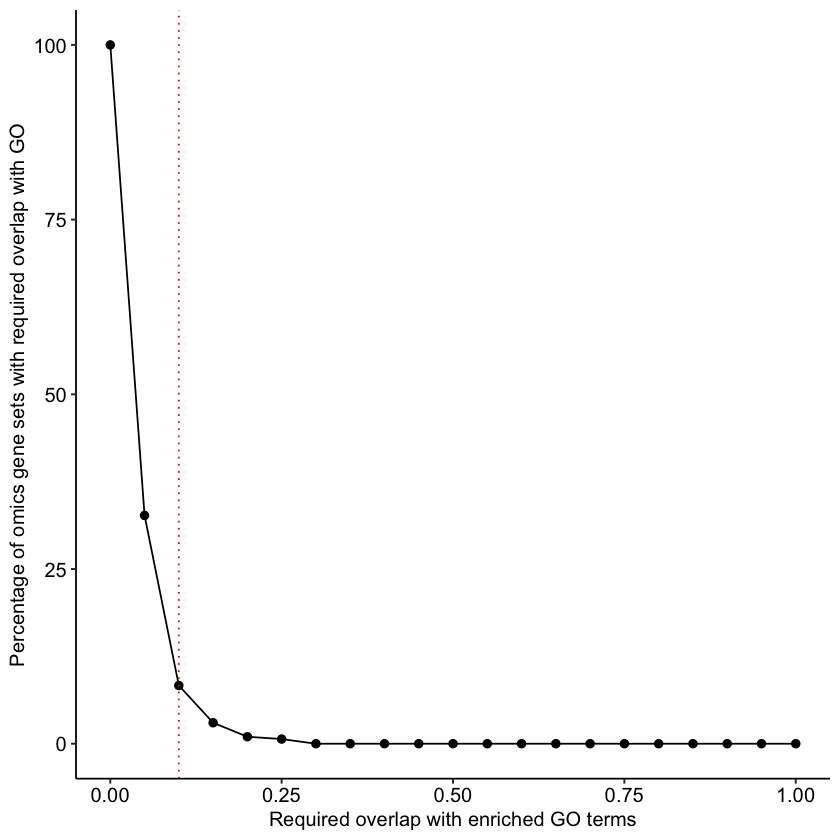

In [22]:
g2


In [23]:
ggsave(filename = "figures/OmicsRevamped_Enrichment_success_onlyThreshold_240613.png", plot = g2,width = 5, height = 3)

In [24]:
ggsave(filename = "figures/OmicsRevamped_Enrichment_success_onlyThreshold_240613.svg", plot = g2,width = 5, height = 3)

In [25]:
geneSets_DF$enrichr_success_TF_0.1 = ((geneSets_DF$`Adjusted P-value` <= enrichr_adj_pval_thresh) & (geneSets_DF$enrichr_JI >= 0.1)) 

In [26]:
write_delim(x = geneSets_DF, file = "data/omics_revamped_LLM_Enrichr_simVals_failure_refs_newThresh_240613_DF.tsv" , 
            delim = "\t")

...1  Unnamed: 0 Source          
1   7148  0          L1000           
2   7149  0          L1000           
3   7150  0          L1000           
4   7153  0          L1000           
5   7254  0          L1000           
6   7374  0          L1000           
7   7375  0          L1000           
8   7417  0          L1000           
9   7439  0          L1000           
10  7440  0          L1000           
11  7441  0          L1000           
12  7442  0          L1000           
13  7443  0          L1000           
14  7444  0          L1000           
15  7445  0          L1000           
16  7459  0          L1000           
17  7491  0          L1000           
18  7523  0          L1000           
19  7543  0          L1000           
20  7577  0          L1000           
21  7594  0          L1000           
22  7625  0          L1000           
23  7626  0          L1000           
24  7628  0          L1000           
25  7643  0          L1000           
26  7663  0          L1000           
27  7678  0          L1000           
28  7679  0          L1000           
29  7680  0          L1000           
30  7681  0          L1000           
⋮   ⋮     ⋮          ⋮               
271 11229 0          Viral_Infections
272 11230 0          Viral_Infections
273 11231 0          Viral_Infections
274 11235 0          Viral_Infections
275 11236 0          Viral_Infections
276 11237 0          Viral_Infections
277 11239 0          Viral_Infections
278 11240 0          Viral_Infections
279 11241 0          Viral_Infections
280 11248 0          Viral_Infections
281 11256 0          Viral_Infections
282 11257 0          Viral_Infections
283 11258 0          Viral_Infections
284 11262 0          Viral_Infections
285 11263 0          Viral_Infections
286 11264 0          Viral_Infections
287 11265 0          Viral_Infections
288 11266 0          Viral_Infections
289 11267 0          Viral_Infections
290 11269 0          Viral_Infections
291 11272 0          Viral_Infections
292 11273 0          Viral_Infections
293 11274 0          Viral_Infections
294 11275 0          Viral_Infections
295 11278 0          Viral_Infections
296 11302 0          Viral_Infections
297 11306 0          Viral_Infections
298 11307 0          Viral_Infections
299 11308 0          Viral_Infections
300 11309 0          Viral_Infections
    GeneSetID                                                                                                         
1   BRD-A00546892_-666_MCF7_6.0_h_10.0_um                                                                             
2   BRD-A00993607_ALPRENOLOL_MCF7_6.0_h_10.0_um                                                                       
3   BRD-A00993607_Alprenolol hydrochloride_MCF7_6.0_h_10.0_um                                                         
4   BRD-A01320529_Salmeterol_MCF7_6.0_h_10.0_um                                                                       
5   BRD-A01346607_FLUMETHASONE_MCF7_6.0_h_10.0_um                                                                     
6   BRD-A01593789_CHLORMADINONE ACETATE_MCF7_6.0_h_10.0_um                                                            
7   BRD-A02006392_NITRENDIPINE_MCF7_6.0_h_10.0_um                                                                     
8   BRD-A02176148_TUBAIC ACID_MCF7_6.0_h_10.0_um                                                                      
9   BRD-A02367930_ETHINYL ESTRADIOL_MCF7_6.0_h_10.0_um                                                                
10  BRD-A02710418_Meptazinol hydrochloride_MCF7_6.0_h_10.0_um                                                         
11  BRD-A02759312_Betaxolol hydrochloride_MCF7_6.0_h_10.0_um                                                          
12  BRD-A04553218_DEXCHLORPHENIRAMINE MALEATE_MCF7_6.0_h_10.0_um                                                      
13  BRD-A04756508_NORGESTIMATE_MCF7_6.0_h_10.0_um                                                    

In [29]:
table(geneSets_DF[,c("enrichr_success_TF_0.1", "LLM_success_TF")])
      

                      LLM_success_TF
enrichr_success_TF_0.1 FALSE TRUE
                 FALSE   163  112
                 TRUE      4   21

In [30]:
?table

table {vctrs},R Documentation
